# Single-Cell RNA-Seq Analysis of Mouse Embryo Cells

This notebook performs dimensionality reduction and visualization of single-cell gene expression data from early mouse embryo development.

The main steps include:
- **Data loading and preprocessing**  
- **Filtering and annotation of cell stages**
- **Principal Component Analysis (PCA)**
- **t-SNE visualization**
- **Diffusion map embedding**

The goal is to explore gene expression patterns across developmental stages and visualize cell differentiation trajectories in reduced dimensions.

*Dataset*: Single-cell RT-qPCR gene expression (442 cells × 48 genes).  
*Tools used*: `scanpy`, `scikit-learn`, `numpy`, `matplotlib`, `seaborn`.

---

## 1. Setup & Imports

We’ll set a global random seed, import all necessary libraries, and define a helper function for 3D plotting of embeddings.

In [19]:
import os
import re
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.ensemble import IsolationForest
from sklearn.metrics import adjusted_rand_score
from scipy.sparse import csr_matrix

# Set global seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure Scanpy for minimal verbosity
sc.settings.verbosity = 2  # show warnings and above
sc.logging.print_header()

%matplotlib inline

# Helper function: modular 3D embedding plot
def plot_3d_embedding(df, xcol, ycol, zcol, stage_col, color_map, title=None, figsize=(8,6)):
    """
    df: DataFrame containing embedding coordinates and 'stage' & 'color' columns
    xcol, ycol, zcol: names of the three embedding dimensions
    stage_col: name of the column with true stage labels
    color_map: dict mapping each stage → a hex color
    title: optional plot title
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    for stage, color in color_map.items():
        sub = df[df[stage_col] == stage]
        ax.scatter(
            sub[xcol],
            sub[ycol],
            sub[zcol],
            label=stage,
            color=color,
            s=40,
            edgecolors='k',
            alpha=0.7
        )
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_zlabel(zcol)
    if title:
        ax.set_title(title)
    ax.legend(title='Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## 2. Load Raw Data & Parse Stages

- Read `mmc4.xls`.  
- Ensure the file exists.  
- Parse `Cell` names with a regex to extract developmental stages.  
- Inspect basic counts and remove any rows with missing data.

In [2]:
FNAME = 'mmc4.xls'
if not os.path.exists(FNAME):
    raise FileNotFoundError(f"Expected to find '{FNAME}' in working directory, but it was not found.")

# Read the Excel file
raw = pd.read_excel(FNAME, engine='xlrd')

# Ensure 'Cell' column exists
if 'Cell' not in raw.columns:
    raise KeyError("The input data must have a 'Cell' column with cell identifiers/stage info.")

# Quick look at missingness & dimensions
print(f"Raw data shape: {raw.shape}")
print(raw.isnull().sum().sort_values(ascending=False).head(10))

# Extract ‘Cell’ column and gene matrix
cells = raw['Cell'].astype(str).copy()
genes_df = raw.drop(columns=['Cell']).copy()

# Drop any rows with missing gene values
mask_complete = genes_df.notnull().all(axis=1)
if not mask_complete.all():
    n_dropped = (~mask_complete).sum()
    print(f"Dropping {n_dropped} cells due to missing gene values.")
    cells = cells[mask_complete].reset_index(drop=True)
    genes_df = genes_df[mask_complete].reset_index(drop=True)
else:
    genes_df = genes_df.reset_index(drop=True)
    cells = cells.reset_index(drop=True)

print(f"After dropping missing: {genes_df.shape[0]} cells × {genes_df.shape[1]} genes")

# Define a regex to capture known stage names.
# Adjust this pattern if your Cell names differ.
import re

# Updated regex to match prefixes: 1C, 2C, 4C, 8C, 16C, 32C, 64C
stage_pattern = re.compile(r'^(1C|2C|4C|8C|16C|32C|64C)', re.IGNORECASE)

def extract_stage(cell_name):
    m = stage_pattern.match(cell_name.strip())
    return m.group(0) if m else 'Unknown'

# Re‐apply to your cells Series
stages = cells.map(extract_stage)
unique_stages = sorted(stages.unique(), key=lambda s: int(s.replace('C', '')))
print("Found stages:", unique_stages)

n_unknown = (stages == 'Unknown').sum()
print(f"Warning: {n_unknown} cells labeled 'Unknown' (ideally 0).")


Raw data shape: (442, 49)
Cell       0
Actb       0
Ahcy       0
Aqp3       0
Atp12a     0
Bmp4       0
Cdx2       0
Creb312    0
Cebpa      0
Dab2       0
dtype: int64
After dropping missing: 442 cells × 48 genes
Found stages: ['1C', '2C', '4C', '8C', '16C', '32C', '64C']


## 3. Build an AnnData, Filter Genes, and Normalize

1. **Gene filtering**  
   - Drop genes expressed in fewer than 3 cells.  
   - Identify highly variable genes (top 2000).  
2. **Total-count normalization** to 10 000 counts-per-cell, followed by `log1p`.  
3. **Store stage & color** in `adata.obs`.


In [3]:
# 3. Build an AnnData, Filter Genes, and Normalize

# 1. Gene filtering
#    - Drop genes expressed in fewer than 3 cells.
#    - Identify highly variable genes (top 2000).
# 2. Total-count normalization to 10 000 counts-per-cell, followed by `log1p`.
# 3. Store stage & color in `adata.obs`.

# Create AnnData: .X will be raw counts (converted to numpy array)
# Ensure observation names are unique
unique_cells = cells.copy()
if unique_cells.duplicated().any():
    unique_cells = unique_cells + '_' + unique_cells.groupby(unique_cells).cumcount().astype(str)
    print("Warning: Duplicate cell names found. Made observation names unique.")

adata = ad.AnnData(X=genes_df.values, obs=pd.DataFrame({'Cell': cells, 'Stage': stages}))
adata.var_names = genes_df.columns.tolist()
adata.obs_names = unique_cells.values # Use unique cell names

# 3.1 Filter genes: remove genes expressed in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)
print(f"After filtering low-expression genes: {adata.n_vars} genes remain")

# 3.2 Identify highly variable genes (HVGs)
# Consider changing flavor if data is not raw counts
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger', subset=True, inplace=True) # Example: change to 'cell_ranger'
# Or use the default:
# sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, inplace=True)
print(f"After selecting HVGs: {adata.n_vars} genes remain (top 2000 by variability)")

# 3.3 Total-count normalization and log1p
sc.pp.normalize_total(adata, target_sum=1e4)  # each cell sums to 1e4 counts
sc.pp.log1p(adata)

# 3.4 Add a ‘Color’ column based on Stage
# Choose a palette of distinct colors
num_stages = len(unique_stages)
base_cmap = plt.get_cmap('tab20')  # up to 20 distinct colors
stage_to_color = {stage: mcolors.to_hex(base_cmap(i)) for i, stage in enumerate(unique_stages)}

adata.obs['Color'] = adata.obs['Stage'].map(stage_to_color)

After filtering low-expression genes: 48 genes remain
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
After selecting HVGs: 48 genes remain (top 2000 by variability)
normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.11/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## 4. Outlier Detection & Removal (Optional)

We’ll use an IsolationForest to flag potential outlier cells in the log-normalized HVG space.

> **Note**: In single-cell workflows, one often filters cells by library size, mitochondrial content, or number of detected genes instead. Here we show IsolationForest only as an example.

In [4]:
# We’ll convert the dense matrix to a numpy array if needed
X_hvg = adata.X if isinstance(adata.X, np.ndarray) else adata.X.toarray()

iso = IsolationForest(contamination=0.01, random_state=RANDOM_STATE)
outlier_labels = iso.fit_predict(X_hvg)  # +1 = inlier, -1 = outlier
mask_inlier = outlier_labels == 1
n_outliers = (outlier_labels == -1).sum()
print(f"IsolationForest flagged {n_outliers} cells as outliers ({n_outliers / adata.n_obs:.2%})")

# Filter adata to keep only inliers
adata = adata[mask_inlier].copy()
print(f"After removing outliers: {adata.n_obs} cells remain")


IsolationForest flagged 5 cells as outliers (1.13%)
After removing outliers: 437 cells remain


## 5. Basic QC Metrics

- Print the number of cells per stage.  
- Print total variance explained by first three PCs.  


In [5]:
# 5.1 Number of cells per stage
stage_counts = adata.obs['Stage'].value_counts().sort_index()
print("\nNumber of cells per stage:")
print(stage_counts)

# 5.2 Compute a quick PCA (on log1p HVG space) to get explained variance
pca_qc = PCA(n_components=10, random_state=RANDOM_STATE)
pcs_qc = pca_qc.fit_transform(adata.X if isinstance(adata.X, np.ndarray) else adata.X.toarray())
var_ratios = pca_qc.explained_variance_ratio_
print("\nExplained variance ratios (first 3 PCs):")
for i, vr in enumerate(var_ratios[:3], start=1):
    print(f"  PC{i}: {vr*100:.2f}%")



Number of cells per stage:
Stage
16C     75
1C       8
2C      19
32C    109
4C      23
64C    159
8C      44
Name: count, dtype: int64

Explained variance ratios (first 3 PCs):
  PC1: 42.15%
  PC2: 11.04%
  PC3: 9.55%


## 6. Principal Component Analysis (PCA)

- Run PCA → 3 components.  
- Build a DataFrame with PC coordinates + metadata.  
- Plot the 3D scatter and report explained variance.



[PCA] Explained variance ratios:
  PC1: 42.15%
  PC2: 11.04%
  PC3: 9.55%


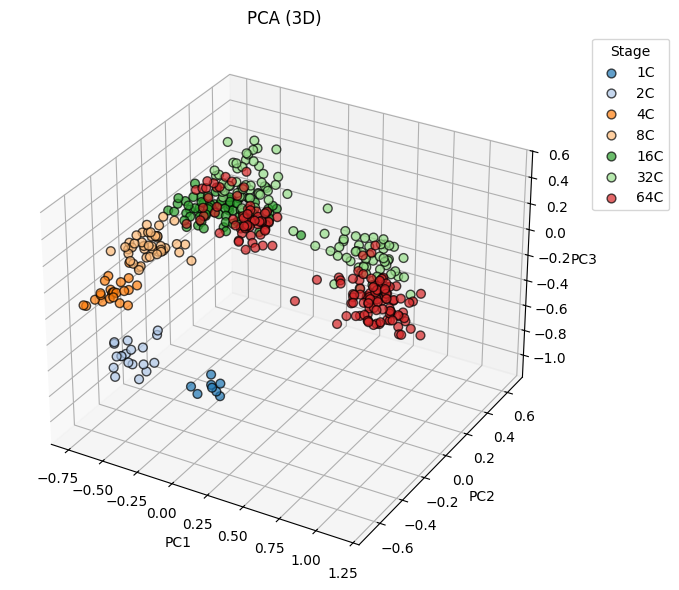

In [20]:
pca = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(adata.X if isinstance(adata.X, np.ndarray) else adata.X.toarray())

# Build a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Stage': adata.obs['Stage'].values,
    'Color': adata.obs['Color'].values
}, index=adata.obs_names)

# Print explained variance
print("\n[PCA] Explained variance ratios:")
for idx, var in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"  PC{idx}: {var*100:.2f}%")

# Plot
plot_3d_embedding(pca_df, 'PC1', 'PC2', 'PC3', 'Stage', stage_to_color, title="PCA (3D)")

## 7. t-SNE (on PCA-reduced space)

- First run PCA to 50 dims, then t-SNE → 3 components.  
- Print the final KL divergence.  
- Plot the 3D scatter.


Running PCA with n_components = 48 (you have 48 genes)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 437 samples in 0.001s...
[t-SNE] Computed neighbors for 437 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 437 / 437
[t-SNE] Mean sigma: 0.267213


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.916431
[t-SNE] KL divergence after 1000 iterations: 0.364041

[t-SNE] Final Kullback–Leibler divergence: 0.3640


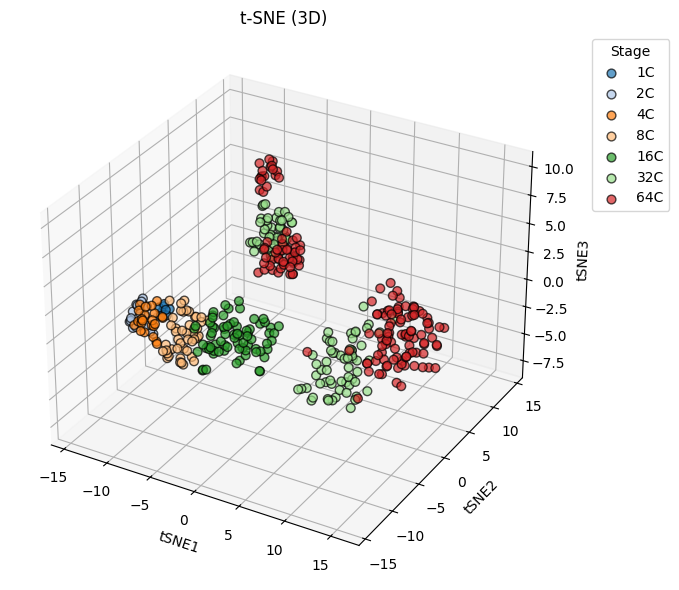

In [14]:
# 7.1 Decide how many PCA dims are actually available (≤ number of genes)
n_pca = min(50, adata.shape[1])
print(f"Running PCA with n_components = {n_pca} (you have {adata.shape[1]} genes)")

pca50 = PCA(n_components=n_pca, random_state=RANDOM_STATE)
X_pca50 = pca50.fit_transform(adata.X if isinstance(adata.X, np.ndarray) else adata.X.toarray())

# 7.2 Run t-SNE on the (up-to-50)-dimensional PCA space
tsne = TSNE(
    n_components=3,
    perplexity=30,
    random_state=RANDOM_STATE,
    n_iter=1000,
    verbose=1
)
X_tsne = tsne.fit_transform(X_pca50)

# Build DataFrame for plotting
tsne_df = pd.DataFrame({
    'tSNE1': X_tsne[:, 0],
    'tSNE2': X_tsne[:, 1],
    'tSNE3': X_tsne[:, 2],
    'Stage': adata.obs['Stage'].values,
    'Color': adata.obs['Color'].values
}, index=adata.obs_names)

# Print final KL divergence
print(f"\n[t-SNE] Final Kullback–Leibler divergence: {tsne.kl_divergence_:.4f}")

# Plot in 3D
plot_3d_embedding(
    tsne_df,
    'tSNE1', 'tSNE2', 'tSNE3',
    'Stage',
    stage_to_color,
    title="t-SNE (3D)"
)

## 8. Diffusion Map (Scanpy)

- Perform PCA to 50 dims → build kNN graph (13 neighbors) → run diffusion map → extract DC2–4 for plotting.  
- Print the first five diffusion eigenvalues.  
- Plot the 3D diffusion embedding.


Running sc.pp.pca with n_comps = 47 (limit was 48, so we use 47).
computing PCA
    with n_comps=47
    finished (0:00:00)
computing neighbors
    finished (0:00:00)
computing Diffusion Maps using n_comps=4(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.        0.9992062 0.9958479 0.9816137]
    finished (0:00:00)

[Diffusion Map] First five diffusion eigenvalues (including trivial zero):
  DC1: 1.000000
  DC2: 0.999206
  DC3: 0.995848
  DC4: 0.981614


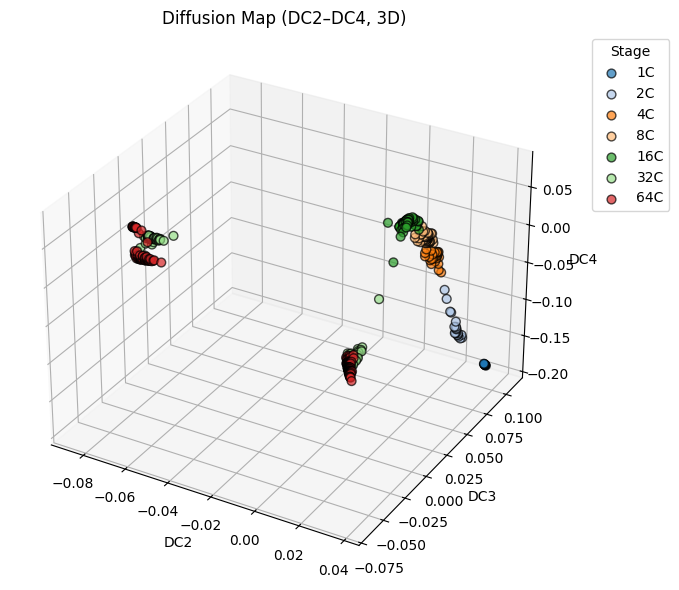

In [16]:
# 8.1 Determine the maximum allowable PCA components
# svd_solver='arpack' requires n_comps < min(n_obs, n_vars)
limit = min(adata.n_obs, adata.n_vars)
if limit <= 1:
    raise ValueError(f"Not enough observations/variables for PCA (limit = {limit}).")

# We want up to 50 components, but strictly less than `limit`
n_pca = min(50, limit - 1)
print(f"Running sc.pp.pca with n_comps = {n_pca} "
      f"(limit was {limit}, so we use {n_pca}).")

# Compute PCA
sc.pp.pca(adata, n_comps=n_pca, random_state=RANDOM_STATE)

# 8.2 Build neighborhood graph (Gaussian kernel) with 13 neighbors, using the PCA representation
sc.pp.neighbors(adata, n_neighbors=13, use_rep='X_pca', method='gauss')

# 8.3 Compute diffusion map (4 components; we’ll skip DC1 for plotting because it’s trivial)
sc.tl.diffmap(adata, n_comps=4)

# Retrieve diffusion components and eigenvalues
dm = adata.obsm['X_diffmap']       # shape = (n_cells, 4)
evals = adata.uns['diffmap_evals'] # eigenvalues array

# Print the first five diffusion eigenvalues
print("\n[Diffusion Map] First five diffusion eigenvalues (including trivial zero):")
for i, eig in enumerate(evals[:5], start=1):
    print(f"  DC{i}: {eig:.6f}")

# Build a DataFrame for DC2–DC4 (skip DC1 because it’s trivial)
dm_df = pd.DataFrame({
    'DC2': dm[:, 1],
    'DC3': dm[:, 2],
    'DC4': dm[:, 3],
    'Stage': adata.obs['Stage'].values,
    'Color': adata.obs['Color'].values
}, index=adata.obs_names)

# Plot DC2–DC4 as a 3D scatter
plot_3d_embedding(
    dm_df,
    'DC2', 'DC3', 'DC4',
    'Stage',
    stage_to_color,
    title="Diffusion Map (DC2–DC4, 3D)"
)
